# Aperture Photometry 1

In [2]:
from glob import glob
from astropy.io import fits
from astropy.visualization import hist
from astropy.modeling import fitting
from astropy.modeling.models import custom_model
fitter = fitting.LevMarLSQFitter()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import scipy.ndimage as ndi
import astropy.stats as astrostats

# configuration
np.set_printoptions(linewidth=120) # para que se vea

cmap = plt.get_cmap("inferno")
cmap.set_bad(color="r")
cmap.set_over(color="w")
if "astro" in plt.colormaps():
    colormaps.unregister("astro")
colormaps.register(cmap,name="astro")
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "astro"
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 15



def quantile_linspace(arr,num=100,lower=0.01,upper=0.99):
    return np.linspace(*np.quantile(np.ravel(arr),[lower,upper]),num=num)

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

def quantile_hist(data,num=100,lower=0.01,upper=0.99):
    return plt.hist(np.ravel(data),bins=quantile_linspace(np.ravel(data),num,lower,upper))

def pseudomode(arr,sigma=1.6,maxiters=20):
    masked = astrostats.sigma_clip(arr,sigma=sigma,maxiters=maxiters)
    return arr[~masked.mask].mean()

# M 92

In [3]:
hdul = fits.open("M92.fits");
images = {hdu.name:hdu.data.astype(float) for hdu in hdul}
headers = {hdu.name:hdu.header for hdu in hdul}
hdul.close()

In [4]:
headers

{'BIAS 25': SIMPLE  =                    T  /  FITS STANDARD                                
 BITPIX  =                   16  /  FITS BITS/PIXEL                              
 NAXIS   =                    2  /  NUMBER OF AXES                               
 NAXIS1  =                  318                                                  
 NAXIS2  =                  507                                                  
 EXTEND  =                    T                                                  
 BSCALE  =       1.0000000000E0  /  REAL = TAPE*BSCALE + BZERO                   
 BZERO   =       0.0000000000E0  /                                               
 OBJECT  = 'ave of 25 bias'      /                                               
 ORIGIN  = 'KPNO-IRAF'           /                                               
 DATE    = '17-09-93'            /                                               
 IRAFNAME= 'm92001.imh'          /  NAME OF IRAF IMAGE FILE                      
 IRAF

## Bias model

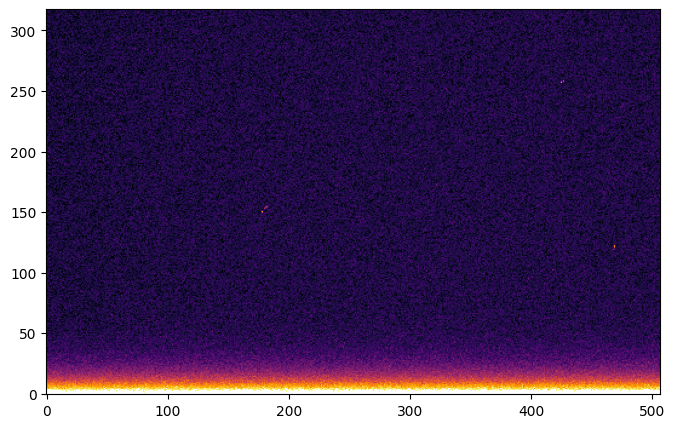

In [5]:
quantile_imshow(images["BIAS 25"].T)

In [6]:
def bias_model(x,y,/,m=0,b=1000,A=300,c=100,n=1):
    return m*x + b + n*x**2 + A*np.exp(-y/c)
BiasModel = custom_model(bias_model)
bias_model = BiasModel()

bias = images["BIAS 25"]
X,Y = np.mgrid[:bias.shape[0],:bias.shape[1]]
bias_model = fitter(bias_model,X,Y,bias)(X,Y)

In [7]:
flat = images["FLAT V 5"]
flat -= bias_model
flat /= flat.mean()

In [197]:
img = images["B 2"] - bias_model
img /= flat

In [198]:
img.shape

(507, 318)

## Source finding

### Masking

In [199]:
X,Y = np.mgrid[:img.shape[0],:img.shape[1]]

In [200]:
mask = (X>15) & (X<470) & (Y>10) & (Y<304)

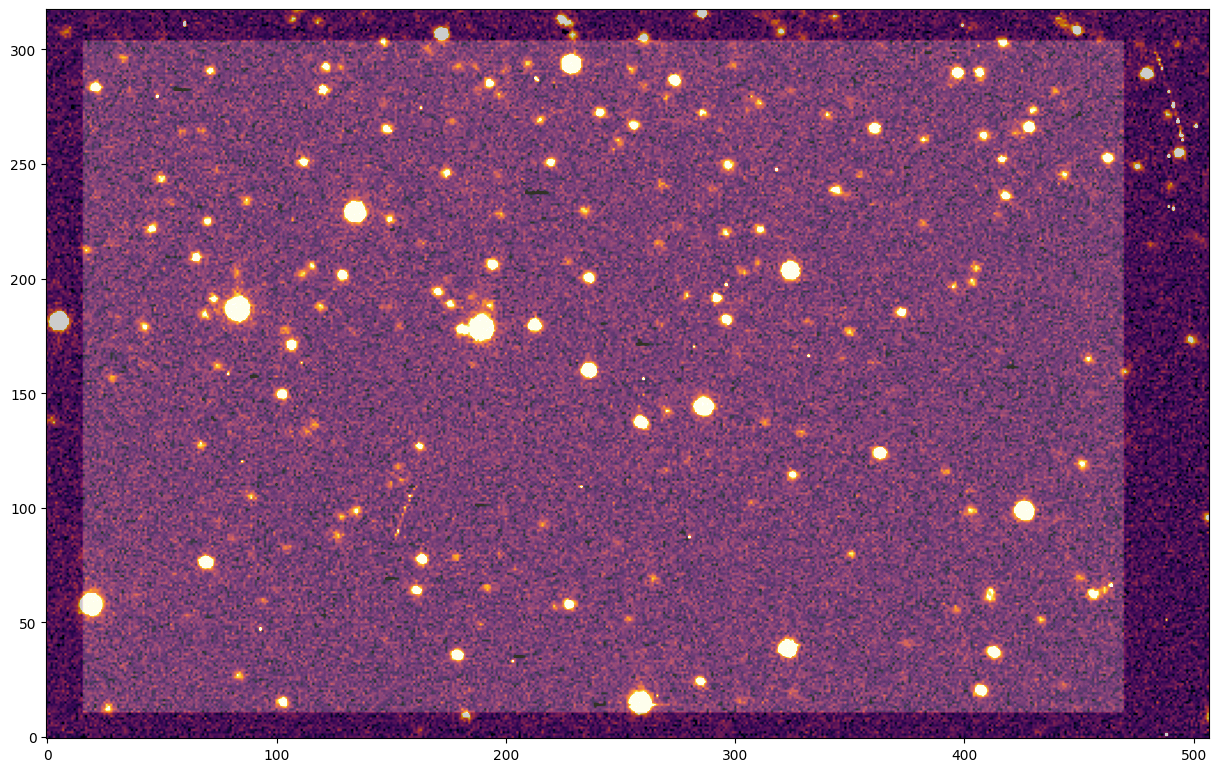

In [201]:
plt.figure(figsize=(15,15))
quantile_imshow(img.T)#,vmin=300,vmax=600)
plt.imshow(mask.T,alpha=0.2)

### Centroids

In [202]:
from skimage.feature import peak_local_max
from photutils.centroids import centroid_sources, centroid_quadratic # can be any of centroid_1dg, centroid_2dg, centroid_com, centroid_quadratic

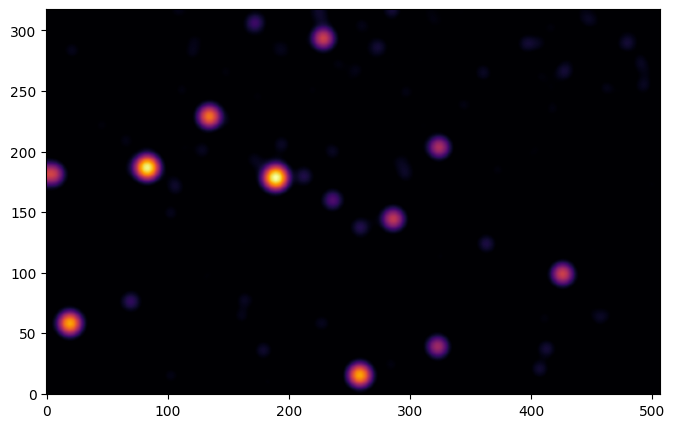

In [203]:
plt.imshow(ndi.gaussian_filter(img,5).T,vmin=50,norm="log")

In [204]:
peaks = peak_local_max(
    ndi.gaussian_filter(img,5),
    threshold_abs=60,
    labels=mask*1,
    min_distance=7,
    exclude_border=20
)

In [205]:
len(peaks)

20

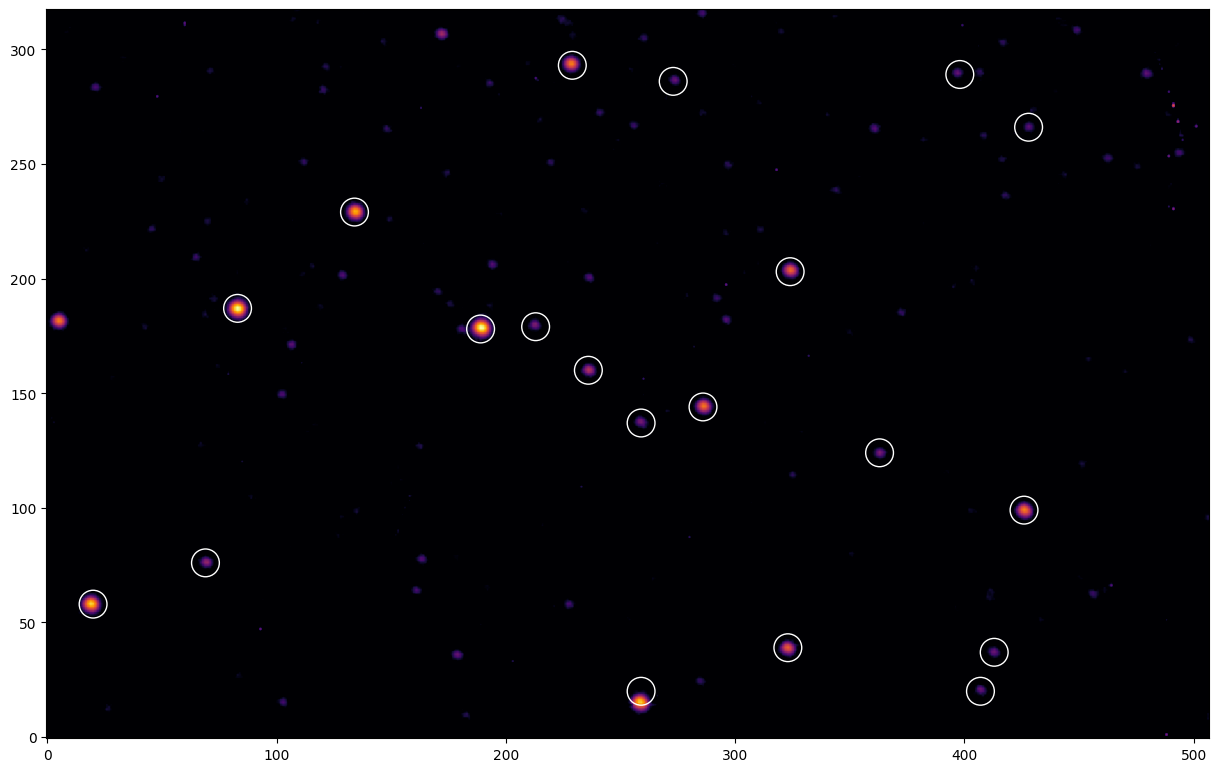

In [206]:
plt.figure(figsize=(15,15))
plt.imshow(img.T,vmin=70,norm="log")
plt.scatter(*peaks.T,fc="none",ec="w",s=400)

In [207]:
centroids = np.array(
    centroid_sources((img-img.mean()).T,*peaks.T,centroid_func=centroid_quadratic,box_size=9)
).T

In [208]:
distances = np.hypot(*(peaks-centroids).T)

In [209]:
distances

array([0.38375666, 0.34324811, 0.82139329, 0.40345996, 4.12310563, 0.20035728, 0.45460015, 0.23146431, 0.26868509,
       0.18214991, 0.24287793, 0.58784022, 0.18193542, 0.6304709 , 0.23680775, 0.15373951, 0.74367797, 1.06642709,
       0.22707081, 0.63470907])

Text(0.5, 0, 'Distance correction [pix]')

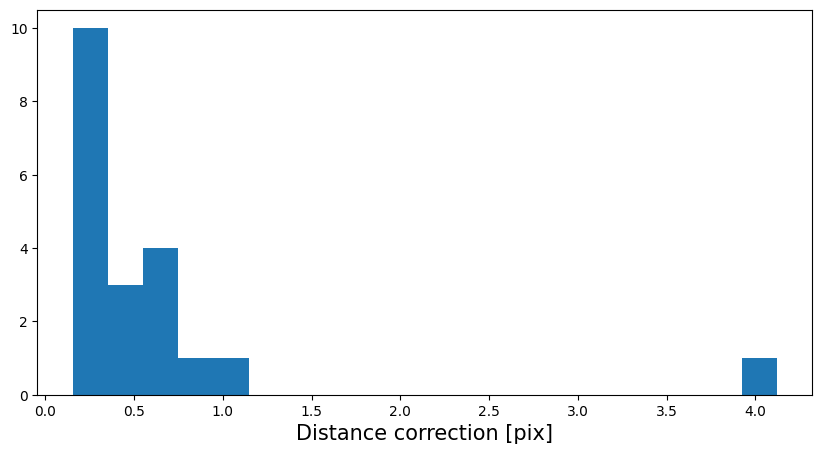

In [210]:
plt.hist(distances,bins=20);
plt.xlabel("Distance correction [pix]")

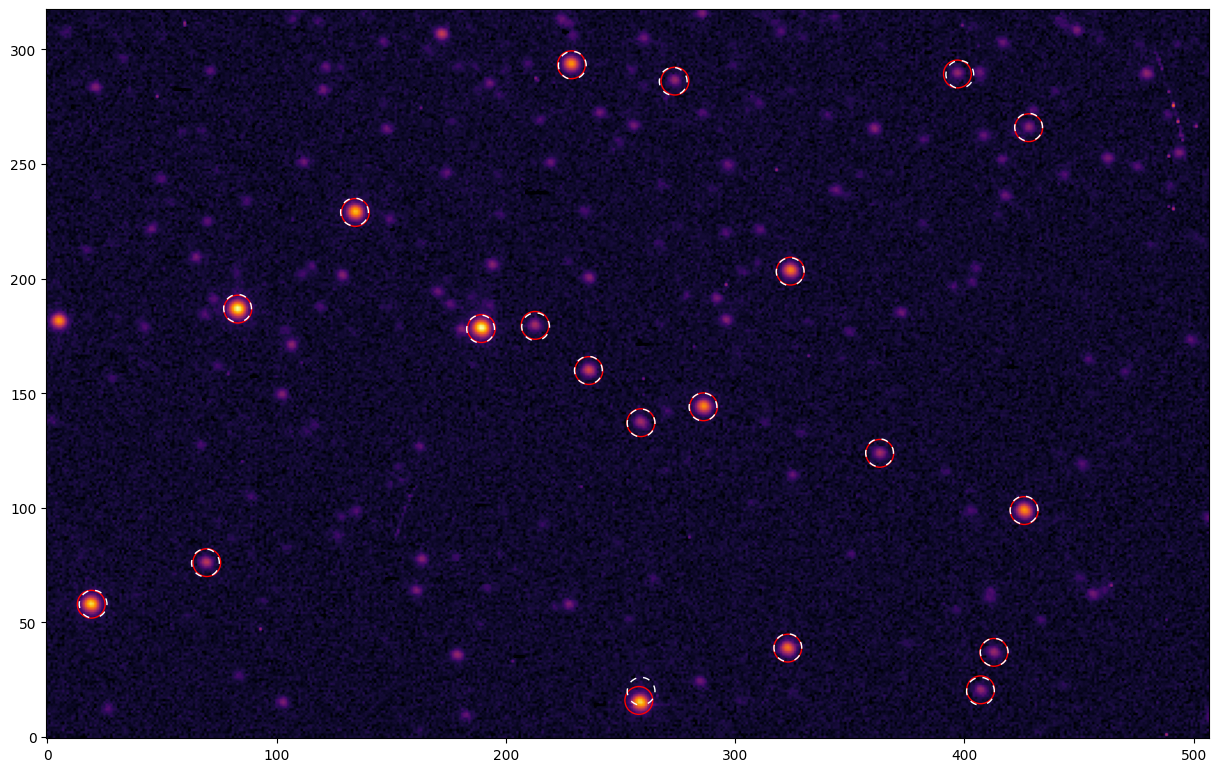

In [211]:
plt.figure(figsize=(15,15))
plt.imshow(img.T,vmin=30,norm="log")
plt.scatter(*centroids.T,fc="none",ec="r",s=400)
plt.scatter(*peaks.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))

## Radial profile and FWHM

In [212]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)

In [213]:
model = Const1D(100) + Gaussian1D(5e3,0,1.5)
model.mean_1.fixed = True

In [214]:
radii = np.arange(0,10,1)
profile = RadialProfile(img.T,centroids[0],radii)
fitted_model = fitter(model,profile.radius,profile.profile)

In [215]:
params = []
params_std = []
for c in centroids:
    try:
        profile = RadialProfile(img.T,c,radii)
        fitted_model = fitter(model,profile.radius,profile.profile)
        params_std.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        params.append(fitted_model.parameters)
    except ValueError:
        pass
    #plt.plot(profile.radius,profile.gaussian_profile)
    #plt.plot(profile.radius,profile.profile,". k")
    #plt.show()
    #plt.close()

params = np.asarray(params)
params_std = np.asarray(params_std)

In [216]:
x = np.log10(params.T[1])
y = 2*np.sqrt(2*np.log(2))*params.T[3]
dx = params_std.T[1]/params.T[1] / np.log(10)
dy = 2*np.sqrt(2*np.log(2))*params_std.T[2]


samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
means = samples.mean(axis=1)

FWHM = means.mean()
FWHM_err = means.std()

Text(0.5, 1.0, 'FWHM mean = $3.443\\pm0.013$')

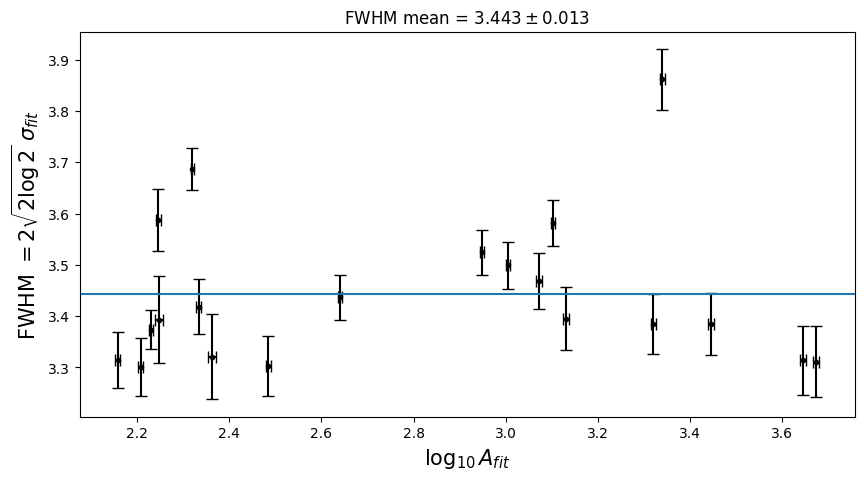

In [217]:
plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)

plt.xlabel("$\\log_{10} A_{fit}$")
plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")

plt.axhline(FWHM)
plt.title(f"FWHM mean = ${FWHM:.3f}\\pm{FWHM_err:.3f}$")

In [218]:
centroids

array([[189.3309401 , 178.19428799],
       [ 83.11352829, 186.67607008],
       [ 19.17965003,  57.95861329],
       [134.36471054, 228.82747127],
       [258.        ,  16.        ],
       [426.07947611,  98.81607994],
       [228.61253956, 293.23777239],
       [286.21733841, 144.07962249],
       [324.11587468, 203.24241439],
       [322.94244949,  38.82718065],
       [236.20885199, 159.87602203],
       [ 69.57807666,  76.1066935 ],
       [258.88614011, 137.14190286],
       [212.74913088, 179.57841009],
       [363.08768807, 123.78002565],
       [412.84723038,  36.9827582 ],
       [273.73486715, 286.11413674],
       [396.95613462, 289.21820134],
       [428.03980706, 265.77644564],
       [407.06670742,  20.63119389]])

In [30]:
!pip install scikit-learn

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 435.7 kB/s eta 0:00:25
   ---------------------------------------- 0.0/10.6 MB 435.7 kB/s eta 0:00:25
   ---------------------------------------- 0.0/10.6 MB 435.7 kB/s eta 0:00:25
   ---------------------------------------- 0.1/10.6 MB 273.8 kB/s eta 0:00:39
   ---------------------------------------- 0.1/10.6 MB 350.1 kB/s eta 0:00:31
   ---------------------------------------- 0.1/10.6 MB 350.1 kB/s eta 0:00:31
   ---------------------------------------- 0.1/10.6 MB 328.2 kB/s eta 0:00:33
    --------------------------------------- 0.2/10.6 MB 409.6 kB/s eta 0:00:26
    --------------------------------------- 0.2/10.6 MB 461.0 kB/s eta 0:00:23
    --------------------------------------- 0.2/10.6 MB 492.1 kB/s eta 0:00:22
    --------------------------------------- 0.3/10.6 MB 477.2 kB/s eta

In [30]:
import sklearn

In [219]:
from sklearn.neighbors import NearestNeighbors

In [220]:
min_distance = NearestNeighbors(n_neighbors=2).fit(centroids).kneighbors(centroids)[0][:,1].min() 
#saca mis datos y mira al siguiente vecino porque el primero es sí mismo. Calcula la distancia minmina
min_distance

17.34324367037366

In [221]:
from photutils.aperture import CircularAnnulus

In [223]:
FWHM

3.4429673099696085

In [224]:
min_distance / FWHM 

5.037295480602966

In [182]:
#Con la distancia cenital puedo calcular la masa de aire. Coef. de extinción * masa de aire

#Hacer todo esto que estamos haciendo con todas las imágenes. V1,V2,B1,B2

In [225]:
r_in = 2.0*FWHM
r_in

6.885934619939217

In [226]:
r_out = 0.7*(min_distance-r_in*0.8)
r_out

8.2841471820956

In [227]:
sky_apertures = CircularAnnulus(centroids, r_in, .7*(min_distance-r_in*0.8))
star_apertures = CircularAperture(centroids, FWHM)

(66.6363184594835, 37.24051439192468)

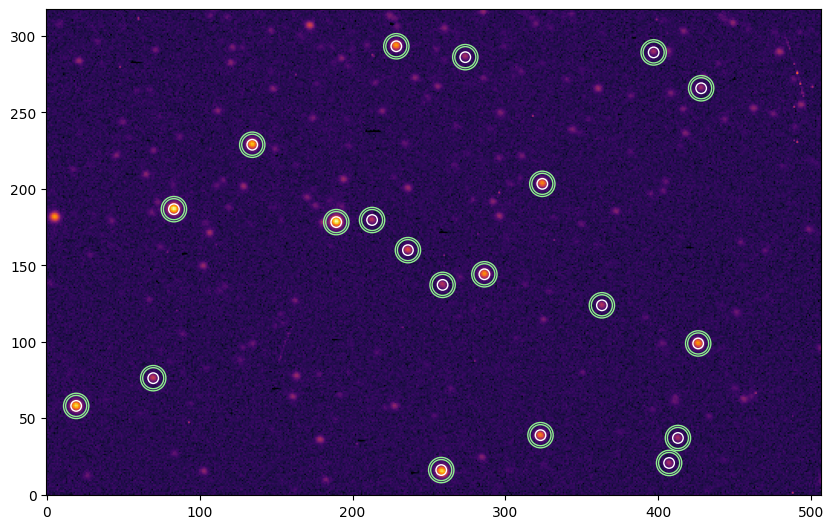

In [228]:
plt.figure(figsize=(10,10))
#quantile_imshow(img.T);
plt.imshow(img.T, vmin=20, norm='log')
sky_apertures.plot(color='lightgreen');
star_apertures.plot(color='w')

sky_apertures.area, star_apertures.area

In [39]:
#Valor del cielo es el promedio de los pixeles del anillo
#A circular annulus y circular aperture les entra el radio

In [229]:
sky_values = ApertureStats(img.T,sky_apertures).median

In [230]:
star_values = ApertureStats(img.T,star_apertures).sum / star_apertures.area 

In [231]:
star_values

array([1666.82419824, 1557.49740758, 1028.77361871,  780.11596567,  973.95500623,  526.09784479,  521.5501339 ,
        475.04742236,  415.24090873,  373.65988583,  201.03607744,  148.61922099,  128.1344951 ,  125.53820852,
        122.15533118,  111.58282525,  105.31332553,  101.7952222 ,   98.5509139 ,  106.94844832])

In [232]:
from photutils.aperture import aperture_photometry

In [233]:
aperture_photometry(img.T, star_apertures)

<QTable length=20>
  id       xcenter            ycenter          aperture_sum   
             pix                pix                           
int32      float64            float64            float64      
----- ------------------ ------------------ ------------------
    1 189.33094009977165  178.1942879878814 62073.390543465524
    2  83.11352828600793 186.67607008159158  58002.00462221269
    3  19.17965002529301  57.95861329054762 38312.058753437734
    4  134.3647105351831  228.8274712738924 29051.919846753564
    5              258.0               16.0  36270.58542668279
    6  426.0794761133817  98.81607994085543 19592.154360501707
    7 228.61253956256738  293.2377723909848 19422.795267752022
    8  286.2173384134901 144.07962248912824 17691.010369069045
    9  324.1158746807955 203.24241439127275 15463.785037838425
   10  322.9424494944058   38.8271806500743 13915.286355867569
   11  236.2088519909794 159.87602203141176  7486.686935163491
   12  69.57807665550725  76.10669350490666  5534.656238174729
   13 258.88614011110985  137.1419028582953  4771.794509001576
   14 212.74913087518868 179.57841009173384   4675.10746106445
   15 363.08768806972523 123.78002565433617  4549.127368786121
   16  412.8472303821541  36.98275819767197  4155.401809492806
   17  273.7348671522062  286.1141367388935  3921.922415079236
   18  396.9561346249267   289.218201342614 3790.9064374440004
   19  428.0398070587905 265.77644564023444 3670.0867273194704
   20  407.0667074241415 20.631193888963004  3982.815228886969

In [234]:
mag_instr = -2.5* np.log10( (star_values - sky_values) / headers["B 2"]["EXPTIME"]) 

In [235]:
mag_instr

array([-2.81687035, -2.74201027, -2.27476556, -1.95776271, -2.21348804, -1.50242221, -1.49448634, -1.374847  ,
       -1.21236081, -1.08605876, -0.27732077,  0.16138006,  0.40595312,  0.43172557,  0.50557262,  0.62250511,
        0.77698026,  0.84807793,  0.96084179,  0.700358  ])

In [236]:
#Zt es el ángulo cenital. Se saca con el header Zenital Distance. La idea es usar la fórmula que nos dan y comparar con la de secante
z = headers["B 1"]["ZD"]
z

'22:42:00.00'

In [237]:
type(z)

str

In [238]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [239]:
z_t = [datetime.strptime(z, '%H:%M:%S.%f')]
z_t

[datetime.datetime(1900, 1, 1, 22, 42)]

In [240]:
arc_min = float(z[:2])
arc_sec = float(z[3:5])/60
radians = (arc_min + arc_sec)/3437.74677
radians, arc_min, arc_sec


(0.006603162338219577, 22.0, 0.7)

In [241]:
#Cálculo de la masa de aire
masa_aire = 1 / (np.cos(radians) + 0.50572*((6.07995 + 90.0 - np.degrees(radians))**(-1.6364)))
masa_aire

0.9997319155314817

In [242]:
air_mass_teo = 1/np.cos(radians)
air_mass_teo

1.0000218012725046

In [243]:
from photutils.utils import calc_total_error

In [244]:
background = np.sqrt(25)*np.std(bias - bias_model)
background_img = np.ones_like(bias)*background
img_err = calc_total_error(img,background_img,10.5)

In [245]:
sky_values_err = ApertureStats(img.T,sky_apertures, sigma_clip=astrostats.SigmaClip()).median
star_values_err = ApertureStats(img.T, star_apertures).sum / star_apertures.area
sky_values_err, star_values_err

(array([59.75177448, 57.86314536, 53.5875942 , 51.85617753, 52.17036893, 47.30226557, 46.24141545, 49.33134962,
        48.6973678 , 47.36914445, 46.11534109, 45.11124611, 45.56461877, 44.90925585, 46.87584968, 43.94662471,
        46.63309634, 45.3796413 , 48.35963849, 43.99231517]),
 array([1666.82419824, 1557.49740758, 1028.77361871,  780.11596567,  973.95500623,  526.09784479,  521.5501339 ,
         475.04742236,  415.24090873,  373.65988583,  201.03607744,  148.61922099,  128.1344951 ,  125.53820852,
         122.15533118,  111.58282525,  105.31332553,  101.7952222 ,   98.5509139 ,  106.94844832]))

In [246]:
#Para hacer este proceso con las otras imágenes puedo hacer una lista y pasarla por todas las funciones que tenemos.

In [247]:
star_errors = [np.linalg.norm( s.to_mask().get_values(img_err.T)/ star_apertures.area) for s in star_apertures]
star_errors

[2.304646596539476,
 2.245934726297001,
 1.9303429054122054,
 1.759962279902427,
 1.8899514203853014,
 1.5711472741622954,
 1.5638803806126051,
 1.529868415660423,
 1.4795553129012058,
 1.4454327586326383,
 1.2863971237907426,
 1.231729911525005,
 1.214597660606406,
 1.2056204545653932,
 1.2077604724775544,
 1.197282890214097,
 1.1889387212743168,
 1.1861399171841644,
 1.1826936809894986,
 1.1893299211381734]

In [248]:
mean_pix_err = np.mean(star_errors)
mean_pix_err

1.4905606412135464

In [58]:
#entregar el FWHM y la fotometría, explicar qué se hizo, cómo se hizo: la magnitud se calcula así, la masa de aire así, etc. Subir el repositorio.
"""
En el informe entregar FWHM, explicar cómo se hizo lo de las distancias, qué constantes usé.
el sigma de los pixeles
Error magnitud estrellas, gráfica de ese error vs magnitud
Masa de aire

"""

'\nEn el informe entregar FWHM, explicar cómo se hizo lo de las distancias, qué constantes usé.\nel sigma de los pixeles\nError magnitud estrellas, gráfica de ese error vs magnitud\nMasa de aire\n\n'

In [249]:
#error magnitud estrellas
err_mag = 2.5*(1/np.log(10))*(np.sqrt(star_values_err**2 + sky_values_err**2)/(abs(sky_values-star_values)))
err_mag


array([1.12710298, 1.12840708, 1.14695148, 1.16561338, 1.14897059, 1.19781319, 1.19603776, 1.21806475, 1.2384117 ,
       1.25330865, 1.44552091, 1.63045206, 1.78832562, 1.79538944, 1.885883  , 1.92510868, 2.13156058, 2.20222988,
       2.40652402, 1.99436883])

In [250]:
len(mag_instr), len(err_mag)

(20, 20)

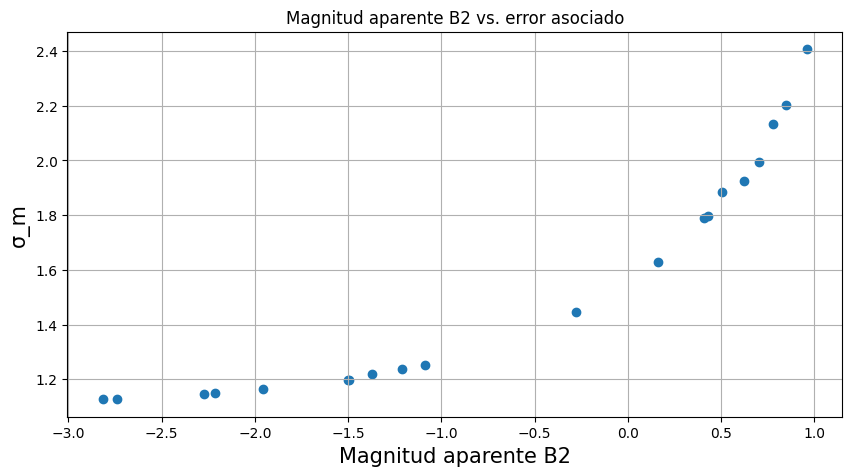

In [251]:
plt.scatter(mag_instr, err_mag)
plt.xlabel('Magnitud aparente B2')
plt.ylabel('σ_m')
#plt.gca().invert_xaxis()
plt.title('Magnitud aparente B2 vs. error asociado')
plt.grid()
plt.savefig('B2 vs. error.png')